### 自编码器的原理
参考论文：《计算机学报》2019.1  自编码神经网络理论及应用综述  袁非牛  
原理简介： 对称结构，分为编码部分和解码部分，目的是解码输出与实际输入一致。 

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
# Hyperparameters
random_seed = 123
learning_rate = 0.001
num_epochs = 5
batch_size = 256

# Architecture
num_features = 784
num_hidden_1 = 32

In [3]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [4]:
class Autoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        
        ### ENCODER
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
       
        ### DECODER
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)


    def forward(self, x):
        
        ### ENCODER
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)
        
        ### DECODER
        logits = self.linear_2(encoded)
        decoded = torch.sigmoid(logits)
        
        return decoded


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(random_seed)
model = Autoencoder(num_features=num_features)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = F.binary_cross_entropy(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/005 | Batch 000/235 | Cost: 0.6983
Epoch: 001/005 | Batch 050/235 | Cost: 0.2343
Epoch: 001/005 | Batch 100/235 | Cost: 0.1864
Epoch: 001/005 | Batch 150/235 | Cost: 0.1637
Epoch: 001/005 | Batch 200/235 | Cost: 0.1480
Time elapsed: 0.22 min
Epoch: 002/005 | Batch 000/235 | Cost: 0.1423
Epoch: 002/005 | Batch 050/235 | Cost: 0.1357
Epoch: 002/005 | Batch 100/235 | Cost: 0.1277
Epoch: 002/005 | Batch 150/235 | Cost: 0.1235
Epoch: 002/005 | Batch 200/235 | Cost: 0.1208
Time elapsed: 0.49 min
Epoch: 003/005 | Batch 000/235 | Cost: 0.1187
Epoch: 003/005 | Batch 050/235 | Cost: 0.1114
Epoch: 003/005 | Batch 100/235 | Cost: 0.1095
Epoch: 003/005 | Batch 150/235 | Cost: 0.1085
Epoch: 003/005 | Batch 200/235 | Cost: 0.1079
Time elapsed: 0.75 min
Epoch: 004/005 | Batch 000/235 | Cost: 0.1038
Epoch: 004/005 | Batch 050/235 | Cost: 0.1065
Epoch: 004/005 | Batch 100/235 | Cost: 0.1035
Epoch: 004/005 | Batch 150/235 | Cost: 0.1008
Epoch: 004/005 | Batch 200/235 | Cost: 0.0975
Time elapse

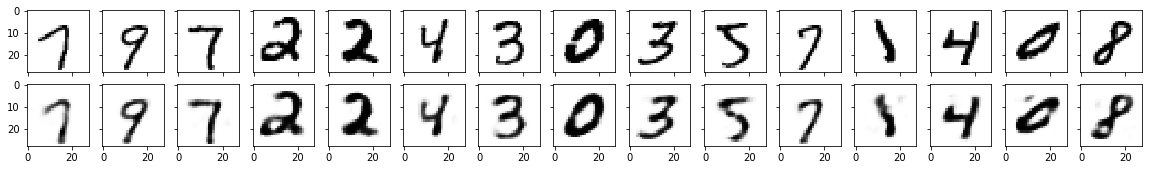

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')